# 6. Training an AU visualization model
*written by Eshin Jolly*

This tutorial illustrates how we trained an AU visualization model in py-feat that can take a vector of AUs and output corresponding facial landmarks. This makes it possible to visualize facial expressions from AU detections by applying a learned transformation to a neutral template face.

To train the model we aggregate AU label and landmark data from the EmotioNet, DISFA Plus, and BP4d datasets. Detailed code on how to do that can be found in the [extracting labels and landmarks notebook](./07_extract_labels_and_landmarks.ipynb). You'll need to run the extraction once for each dataset before you can train the AU visualization model with the code presented here. 

This tutorial assumes that the extracted csv files are in the `data/extracted_labels_landmarks` folder at the root of this repository. And that files are names as (lowercase) `[dataset]_labels.csv` and `[dataset]_landmarks.csv`

If you're adding new AU Detectors, it me useful to also include a visualization model for your specific detector, especially if the number or AU outputs differ from our included visualization model (20 AUs): 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 17, 20, 23, 24, 25, 26, 28, 43.

In [this section](#jaanet-visualization-model) of the notebook you can see how we train a separate visualization model for the JAANET AU detector

## Imports and Paths

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import h5py
from feat.utils import get_resource_path, load_viz_model
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn import __version__ as skversion
from joblib import dump
from pathlib import Path
from feat.pretrained import AU_LANDMARK_MAP
from typing import List, Union, Tuple

sns.set_style("white")

# Set data directory to data folder relative to location of this notebook
here = Path(os.path.realpath(""))
base_dir = here.parent.parent
data_dir = base_dir / "data" / "extracted_labels_landmarks"

# Get the 20 AUs we use for training the model
au_cols = AU_LANDMARK_MAP["Feat"]
print(f"Using {len(au_cols)} AUs")


Using 20 AUs


## Load, clean, and aggregate extracted labels and landmarks

First we load up the 3 datasets containing AU labels and facial landmarks and concatenate them into 2 dataframes. All AU values are also rescaled to 0-1 indicating the *presence* of an AU for that sample.

In [2]:
def load_landmark_au_data(
    au_cols: List, verbose: bool = True, concat: bool = True
) -> Union[Tuple[pd.DataFrame, pd.DataFrame], Tuple[List, List]]:

    """Load and concatenate the emotionet, difsaplus, and bp4d datasets"""

    labels, landmarks = [], []
    for name in ["emotionet", "disfaplus", "bp4d"]:

        labels_file, landmarks_file = f"{name}_labels.csv", f"{name}_landmarks.csv"

        labels_df = (
            pd.read_csv(data_dir / labels_file)
            .replace({999: np.nan, 9: np.nan})
            .drop(columns=["URL"], errors="ignore")
            .pipe(lambda df: df.astype("float") / 5 if name == "disfaplus" else df)
            .fillna(0)
        )
        if verbose:
            print(f"{name}: {labels_df.shape[0]}")
        labels.append(labels_df)
        landmarks_df = pd.read_csv(os.path.join(data_dir, landmarks_file))
        landmarks.append(landmarks_df)

    if concat:
        labels = pd.concat(labels, axis=0, ignore_index=True)[au_cols].fillna(0)
        landmarks = pd.concat(landmarks, axis=0, ignore_index=True).fillna(0)
    else:
        labels = list(map(lambda df: df.fillna(0), labels))
        landmarks = list(map(lambda df: df.fillna(0), landmarks))

    if verbose and concat:
        print(f"Aggregated landmarks: {landmarks.shape}")
        print(f"Aggregated labels: {labels.shape}")

    return labels, landmarks


In [38]:
labels, landmarks = load_landmark_au_data(au_cols=au_cols)

emotionet: 24587
disfaplus: 57668
bp4d: 143951
Aggregated landmarks: (226206, 136)
Aggregated labels: (226206, 20)


We can examine the correlation between AU occurences across all the datasets to get a sense of what AU's tend to co-occur:

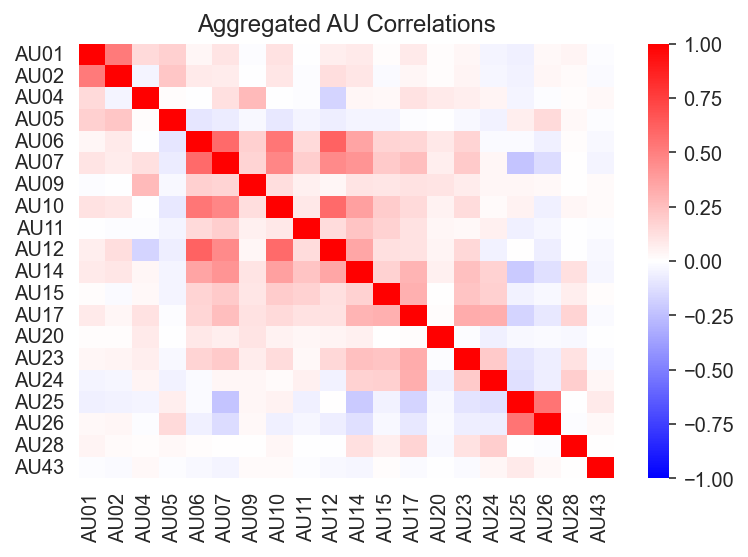

In [6]:
ax = sns.heatmap(labels.corr(), cmap='bwr', vmin=-1, vmax=1)
_ = ax.set(title='Aggregated AU Correlations')

However, due to differences in the AUs included in each dataset, these correlations vary:

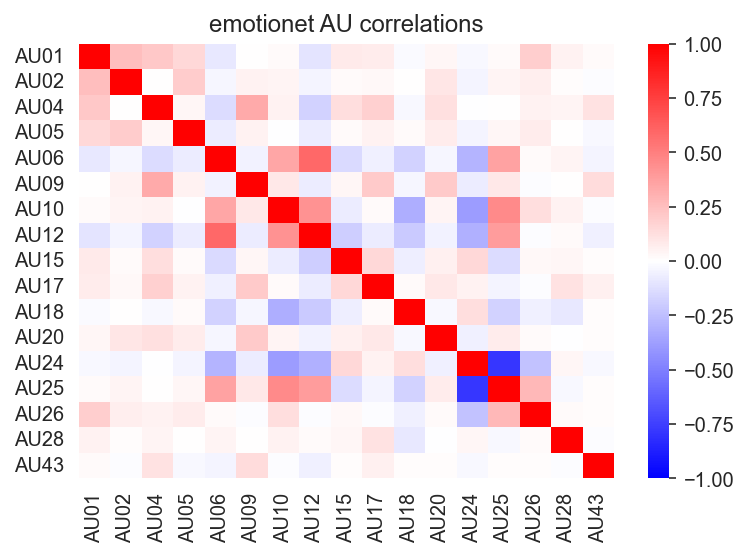

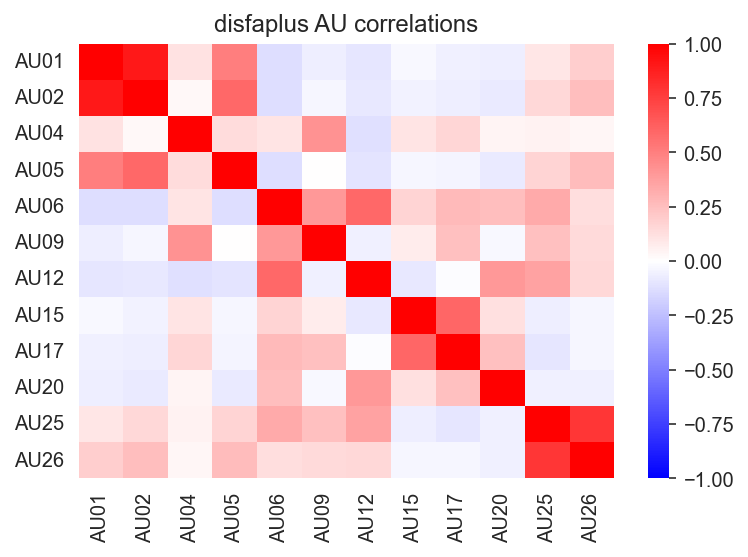

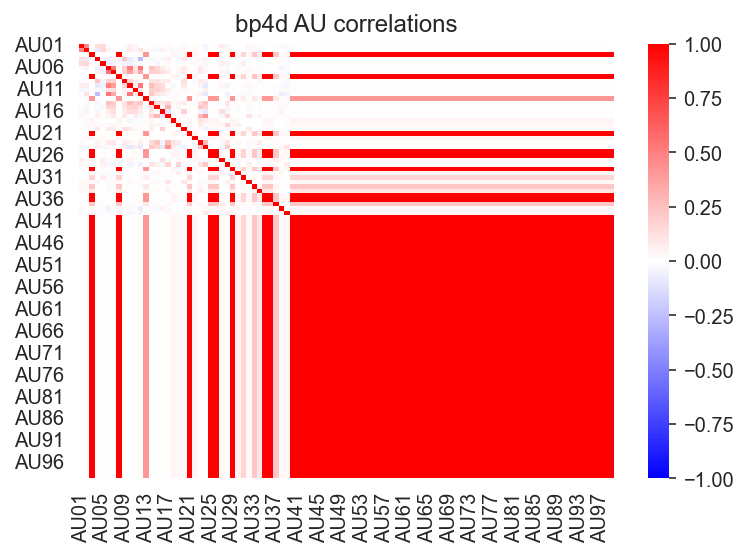

In [12]:
labels_list, landmarks_list = load_landmark_au_data(au_cols=au_cols, concat=False, verbose=False)

for label, name in zip(labels_list, ['emotionet', 'disfaplus', 'bp4d']):
    f, ax = plt.subplots(1,1)
    ax = sns.heatmap(label.corr(), cmap='bwr', vmin=-1, vmax=1, ax=ax)
    _ = ax.set(title=f"{name} AU correlations")
    

## Balance AU-occurences by sub-sampling

Because datasets differ in which AUs they contain and because AUs differ greatly in their occurence across samples, we sub-sample the aggregated data to generate a new dataset that contains at least 650 occurences of each AU. This number was chosen because it is the largest number of positive samples (samples where the AU was present) for the AU with the fewest positive samples (AU43). This helps balance the features out a bit:

In [10]:
def pseudo_balance_au_occurences(
    labels, au_cols, min_pos_sample=650, verbose=True, random_state=0
):
    """Sub-sample the labels dataframe so for each AU at least min_pos_sample rows
    contain an instance of that AU. This will generate a new dataset of shape
    min_pos_sample * len(au_cols) x len(au_cols)"""
    if min_pos_sample > labels.sum().min():
        raise ValueError(f"min_pos_sample must be {labels.sum().min()} or lower")

    if verbose:
        print("Pseudo balancing samples")
    balY = pd.DataFrame()
    balX = pd.DataFrame()
    for AU in labels[au_cols].columns:
        if np.sum(labels[AU] == 1) > min_pos_sample:
            replace = False
        else:
            replace = True
        newSample = labels[labels[AU] > 0.5].sample(
            min_pos_sample, replace=replace, random_state=random_state
        )
        balX = pd.concat([balX, newSample])
        balY = pd.concat([balY, landmarks.loc[newSample.index]])

    # Make sure we have more occurrences of each AU than in the original dataset
    assert all(balX.mean() > labels.mean())

    return balX, balY

This gives us a new dataset of shape:  
(650 * 20) x 20

In [39]:
# Random-state for reproducibility
balX, balY = pseudo_balance_au_occurences(
    labels, au_cols, min_pos_sample=650, random_state=0
)
print(f"Resampled dataset shape: {balX.shape}")

Pseudo balancing samples
Resampled dataset shape: (13000, 20)


We can see that our resampled dataset contains signficantly higher proportions of each AU, which will make it a bit easier to train the model.

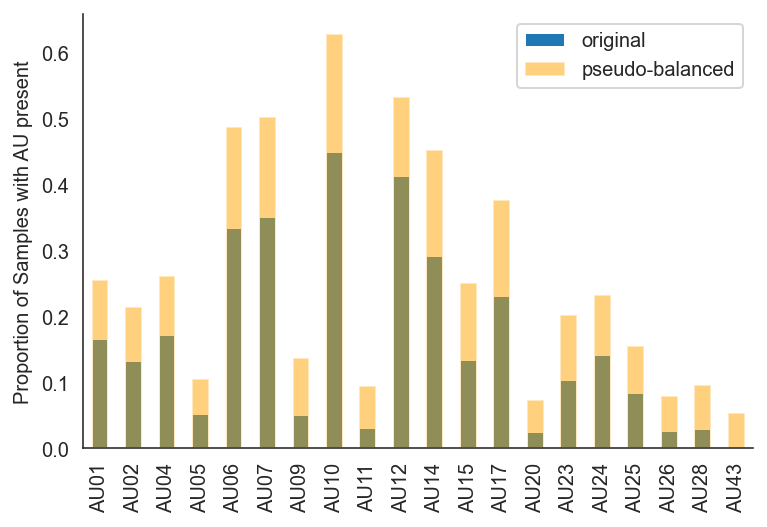

In [18]:
ax = labels.mean().plot(kind="bar", label="original")
ax = balX.mean().plot(
    kind="bar", color="orange", alpha=0.5, ax=ax, label="pseudo-balanced"
)
_ = ax.legend()
_ = ax.set(ylabel='Proportion of Samples with AU present')
sns.despine()

## Fit PLSRegression model

Finally we can train a partial-least-squares regression model to map between AUs and facial landmarks. We first align facial landmarks to a template *neutral expression* face. This will allow us to use the regression weights to "warp" this face to display various expressions. To validate our model, we test predictive performance out-of-sample using 3-fold cross-validation. We also return the overall-fit across the full (resampled) data. 

In [19]:
def preprocess_features(
    X, Y, align_landmarks_to_neutral=True, scale_across_features=False, poly_degree=1
):
    """Take dataframes of labels and landmarks and prepare them for PLSRegression estimator"""
    from feat.utils import registration, neutral
    from sklearn.preprocessing import scale

    _X = X.to_numpy()

    # We can optionally add more features prior to model fitting by creating new columns
    # that capture the interactions between 2, 3, or more AUs via polynomial terms
    # This might help model performance, at the cost of over-fitting so feel free to
    # play around with this. 
    # We don't include any polynomial terms by default
    if poly_degree > 1:
        from sklearn.preprocessing import PolynomialFeatures

        poly = PolynomialFeatures(
            degree=poly_degree, interaction_only=True, include_bias=False
        )
        _X = poly.fit_transform(_X)

    # It can also be helpful to scale AUs within each sample such that they reflect
    # z-scores relative to the mean/std AU occurences within that sample, rather than
    # values between 0-1. This can be helpful if you use a polynomial degree > 1
    # But we don't do this by default
    if scale_across_features:
        _X = scale(_X, axis=1)

    _Y = Y.to_numpy()

    if align_landmarks_to_neutral:
        _Y = registration(_Y, neutral)

    print(f"Data shape: {_X.shape}\n")
    return _X, _Y


def fit_pls(
    X,
    Y,
    n_splits=3,
    refit_full=True,
    n_components=20,
    max_iter=2000,
):
    """Fit and validate a PLSRegression model"""

    outstr = f"Components: {n_components}\n"

    if n_splits is not None:
        kf = KFold(n_splits=n_splits)
        scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            clf = PLSRegression(n_components=n_components, max_iter=max_iter)
            _ = clf.fit(X_train, y_train)
            scores.append(clf.score(X_test, y_test))

        outstr += f"Test R^2 ({n_splits}-fold): {np.round(np.mean(scores),3)}"

    clf = None
    if refit_full:
        clf = PLSRegression(n_components=n_components, max_iter=2000)
        _ = clf.fit(X, Y)
        outstr += f"\tFull R^2: {np.round(clf.score(X, Y), 3)}\n"

    print(outstr)
    return clf



We can start by examiningd how changing the amount of dimensionality-reduction (number of PLS components) affect the model performance using just original 20d AUs: 

In [40]:
X, Y = preprocess_features(balX,balY)

clf = fit_pls(X, Y, n_components=len(au_cols))


Data shape: (13000, 20)

Components: 20
Test R^2 (3-fold): 0.12	Full R^2: 0.155



## Saving and loading trained model
We save and package the trained visualization model in two ways:
1. Using `joblib.dump` as recommended by the [sklearn docs](https://scikit-learn.org/stable/modules/model_persistence.html). This is the default model that gets loaded if your installed Python and sklearn `major.minor` versions match those the model was originally trained with
2. As an HDF5 file with the necessary attributes to initialize a new `PLSRegression` object on any system. This is the fallback that gets loaded if your installed Python and sklearn `major.minor` versions don't match what the model was originally trained with

In [21]:
def save_viz_model(model_name, clf):

    # Add some extra attributes to the model instance and dump it
    clf.X_train = X
    clf.Y_train = Y
    clf.skversion = skversion
    clf.pyversion = sys.version
    clf.model_name_ = model_name
    _ = dump(clf, os.path.join(get_resource_path(), f"{model_name}.joblib"))

    # Do the same as an hdf5 file
    hf = h5py.File(os.path.join(get_resource_path(), f"{model_name}.h5"), "w")
    _ = hf.create_dataset("coef", data=clf.coef_)
    _ = hf.create_dataset("x_weights", data=clf.x_weights_)
    _ = hf.create_dataset("x_mean", data=clf._x_mean)
    _ = hf.create_dataset("y_mean", data=clf._y_mean)
    _ = hf.create_dataset("x_std", data=clf._x_std)
    _ = hf.create_dataset("y_std", data=clf._y_std)
    _ = hf.create_dataset("y_weights", data=clf.y_weights_)
    _ = hf.create_dataset("x_loadings", data=clf.x_loadings_)
    _ = hf.create_dataset("y_loadings", data=clf.y_loadings_)
    _ = hf.create_dataset("x_scores", data=clf.x_scores_)
    _ = hf.create_dataset("y_scores", data=clf.y_scores_)
    _ = hf.create_dataset("x_rotations", data=clf.x_rotations_)
    _ = hf.create_dataset("y_rotations", data=clf.y_rotations_)
    _ = hf.create_dataset("intercept", data=clf.intercept_)
    _ = hf.create_dataset("x_train", data=clf.X_train)
    _ = hf.create_dataset("y_train", data=clf.Y_train)
    hf.attrs["skversion"] = clf.skversion
    hf.attrs["pyversion"] = clf.pyversion
    hf.attrs["model_name"] = clf.model_name_
    hf.close()
    print("Model saved!")


In [22]:
save_viz_model("pyfeat_aus_to_landmarks", clf)

Model saved!


/Users/Esh/anaconda3/envs/py-feat/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


Now we can use the `load_viz_model` from `feat.utils` to try loading our model. This function will try to load a `.joblib` file if your major.minor version of sci-kit learn match those that the model was originally trained with. Otherwise it will fallback to loading a `.h5` file and reconstructing the estimator attributes.

If you don't pass in a model name, the model we just trained is what gets loaded by default:

In [44]:
loaded_model = load_viz_model('pyfeat_aus_to_landmarks', verbose=True)
loaded_model

Loading joblib


PLSRegression(max_iter=2000, n_components=20)

We can make sure the loaded trained models are the same by comparing their learned coefficients and their performance on the aggregated data:

In [43]:
loaded_model.score(X,Y) == clf.score(X,Y)
np.allclose(loaded_model.coef_, clf.coef_)

True

/Users/Esh/anaconda3/envs/py-feat/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


True

## Visualizing detections using model

Now you can visualize AU detections by passing setting `faces='aus'` to the `.plot_detections()` method of a `Fex` dataclass:

/Users/Esh/anaconda3/envs/py-feat/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


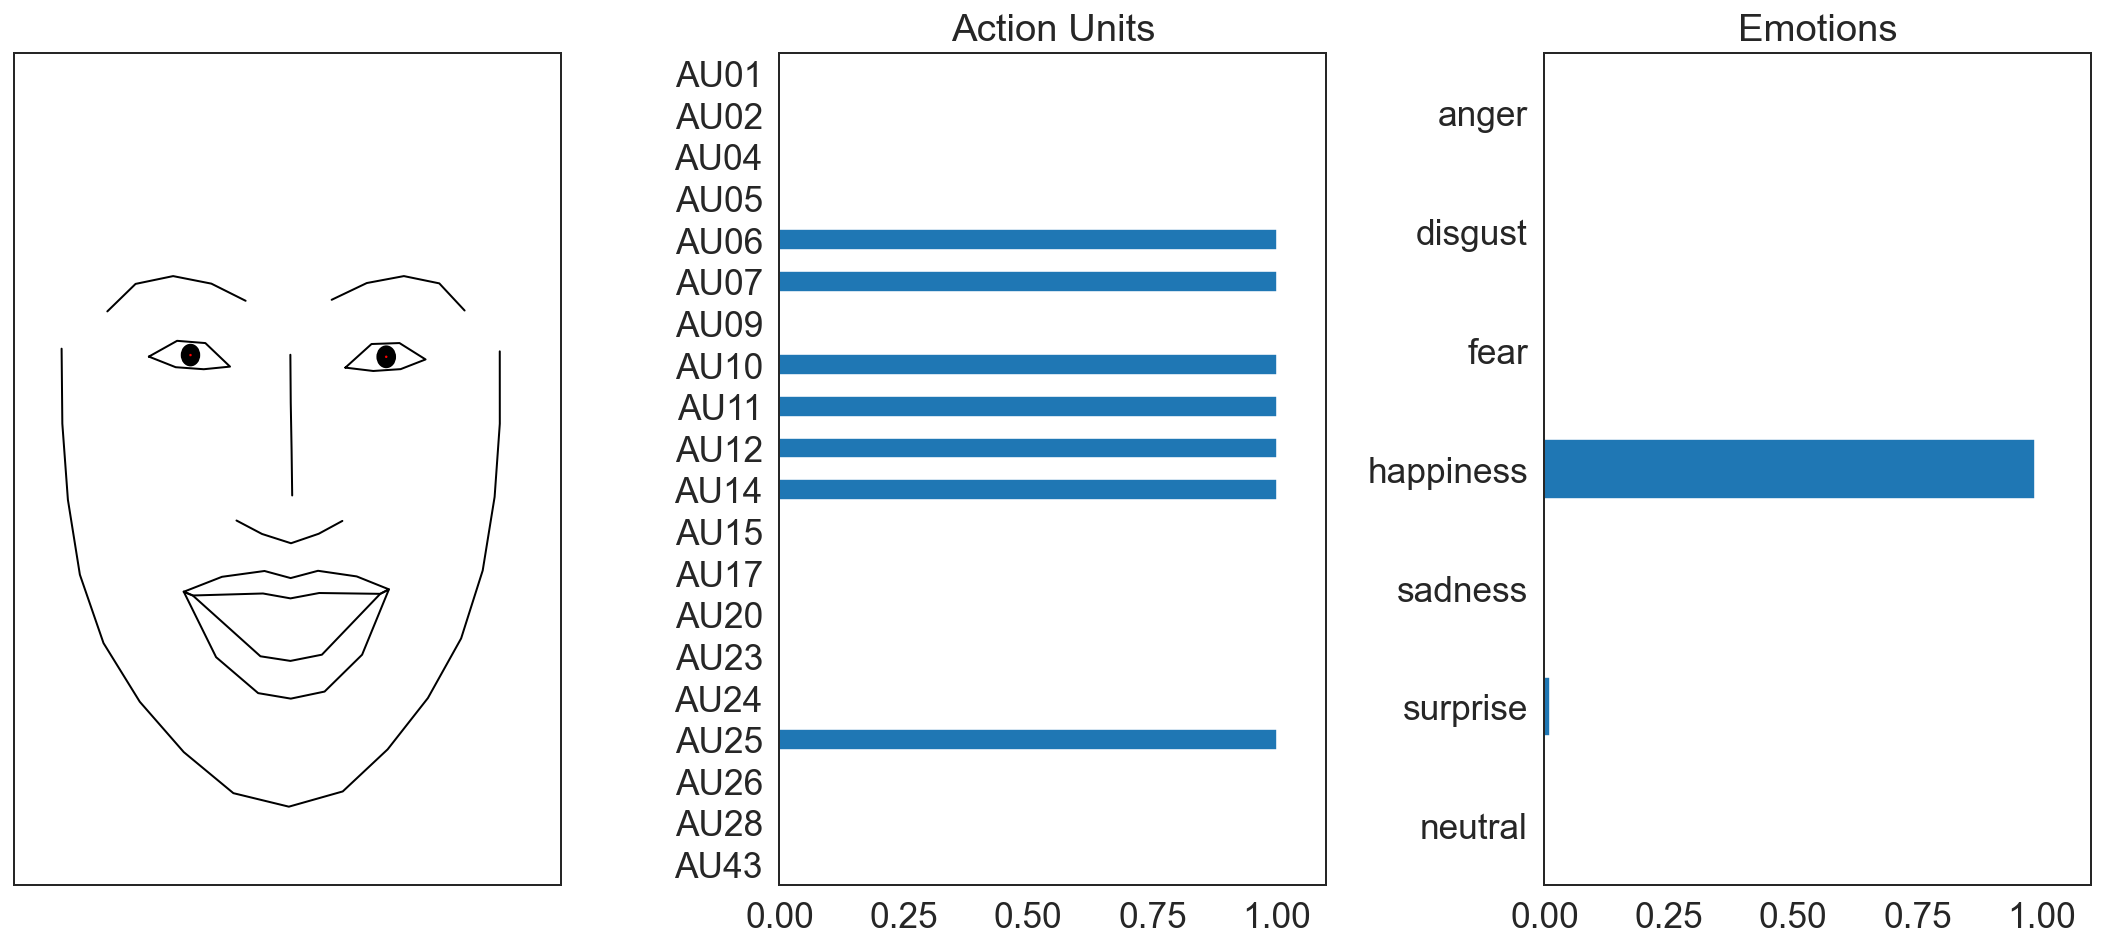

In [47]:
from feat import Detector
from feat.utils import get_test_data_path

single_face_img_path = os.path.join(get_test_data_path(), "single_face.jpg")

# Both the svm and logistic au models will use our visualization model
detector = Detector(au_model='svm')

single_face_prediction = detector.detect_image(single_face_img_path)
figs = single_face_prediction.plot_detections(faces= 'aus', add_titles=False)

## JAANET Visualization Model

Here we perform the same model training as before but this time using only the 12 AUs detected by JAANET: 1, 2, 4, 6, 7, 10, 12, 14, 15, 17, 23, 24. 

You can use a similar approach if you plan to add a custom AU detector that has a different set of AUs. You should use the naming convention: `[detector]_aus_to_landmarks` when saving models to disk

Using 12 AUs
emotionet: 24587
disfaplus: 57668
bp4d: 143951
Aggregated landmarks: (226206, 136)
Aggregated labels: (226206, 12)
Pseudo balancing samples
Resampled dataset shape: (7800, 12)


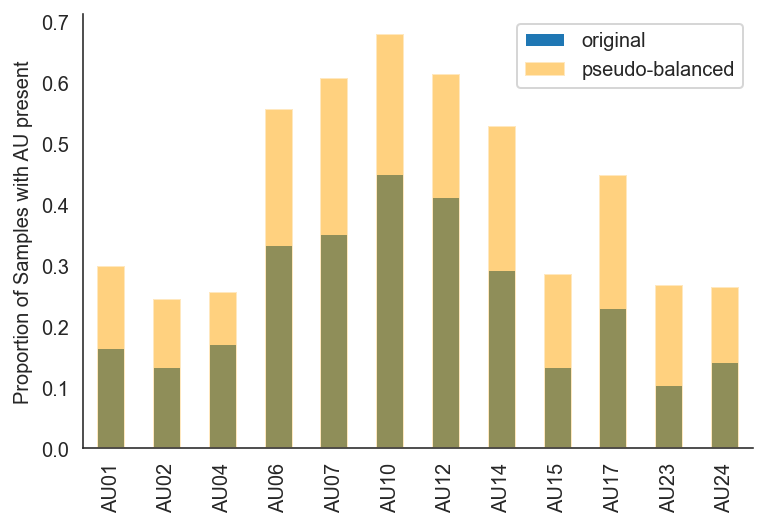

In [26]:
# Get list of JAANET AUs
jaanet_au_cols = AU_LANDMARK_MAP["jaanet"]
print(f"Using {len(jaanet_au_cols)} AUs")

# Load and aggregate only these 12 AUs from the different datasets
labels, landmarks = load_landmark_au_data(au_cols=jaanet_au_cols)

# Pseudo-balance AU occurrences
balX, balY = pseudo_balance_au_occurences(
    labels, jaanet_au_cols, min_pos_sample=650, random_state=0
)
print(f"Resampled dataset shape: {balX.shape}")

# Plot the rebalancing
ax = labels.mean().plot(kind="bar", label="original")
ax = balX.mean().plot(
    kind="bar", color="orange", alpha=0.5, ax=ax, label="pseudo-balanced"
)
_ = ax.legend()
_ = ax.set(ylabel='Proportion of Samples with AU present')
sns.despine()


Then we fit, save, and verify the saved the model like before:

In [27]:
# Align landmarks to the neutral face
X, Y = preprocess_features(balX,balY)

# Fit the model
jaanet_clf = fit_pls(X, Y, n_components=len(jaanet_au_cols))

# Save it
save_viz_model("jaanet_aus_to_landmarks", jaanet_clf)

Data shape: (7800, 12)

Components: 12
Test R^2 (3-fold): 0.088	Full R^2: 0.118

Model saved!


/Users/Esh/anaconda3/envs/py-feat/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [34]:
# Verify the saved model
jaanet_loaded_model = load_viz_model('jaanet_aus_to_landmarks', verbose=True)

jaanet_loaded_model.score(X,Y) == jaanet_clf.score(X,Y)
np.allclose(jaanet_loaded_model.coef_, jaanet_clf.coef_)

Loading joblib


True

/Users/Esh/anaconda3/envs/py-feat/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


True

Finally we can visualize the AU detection:

Changing au_model from svm -> jaanet


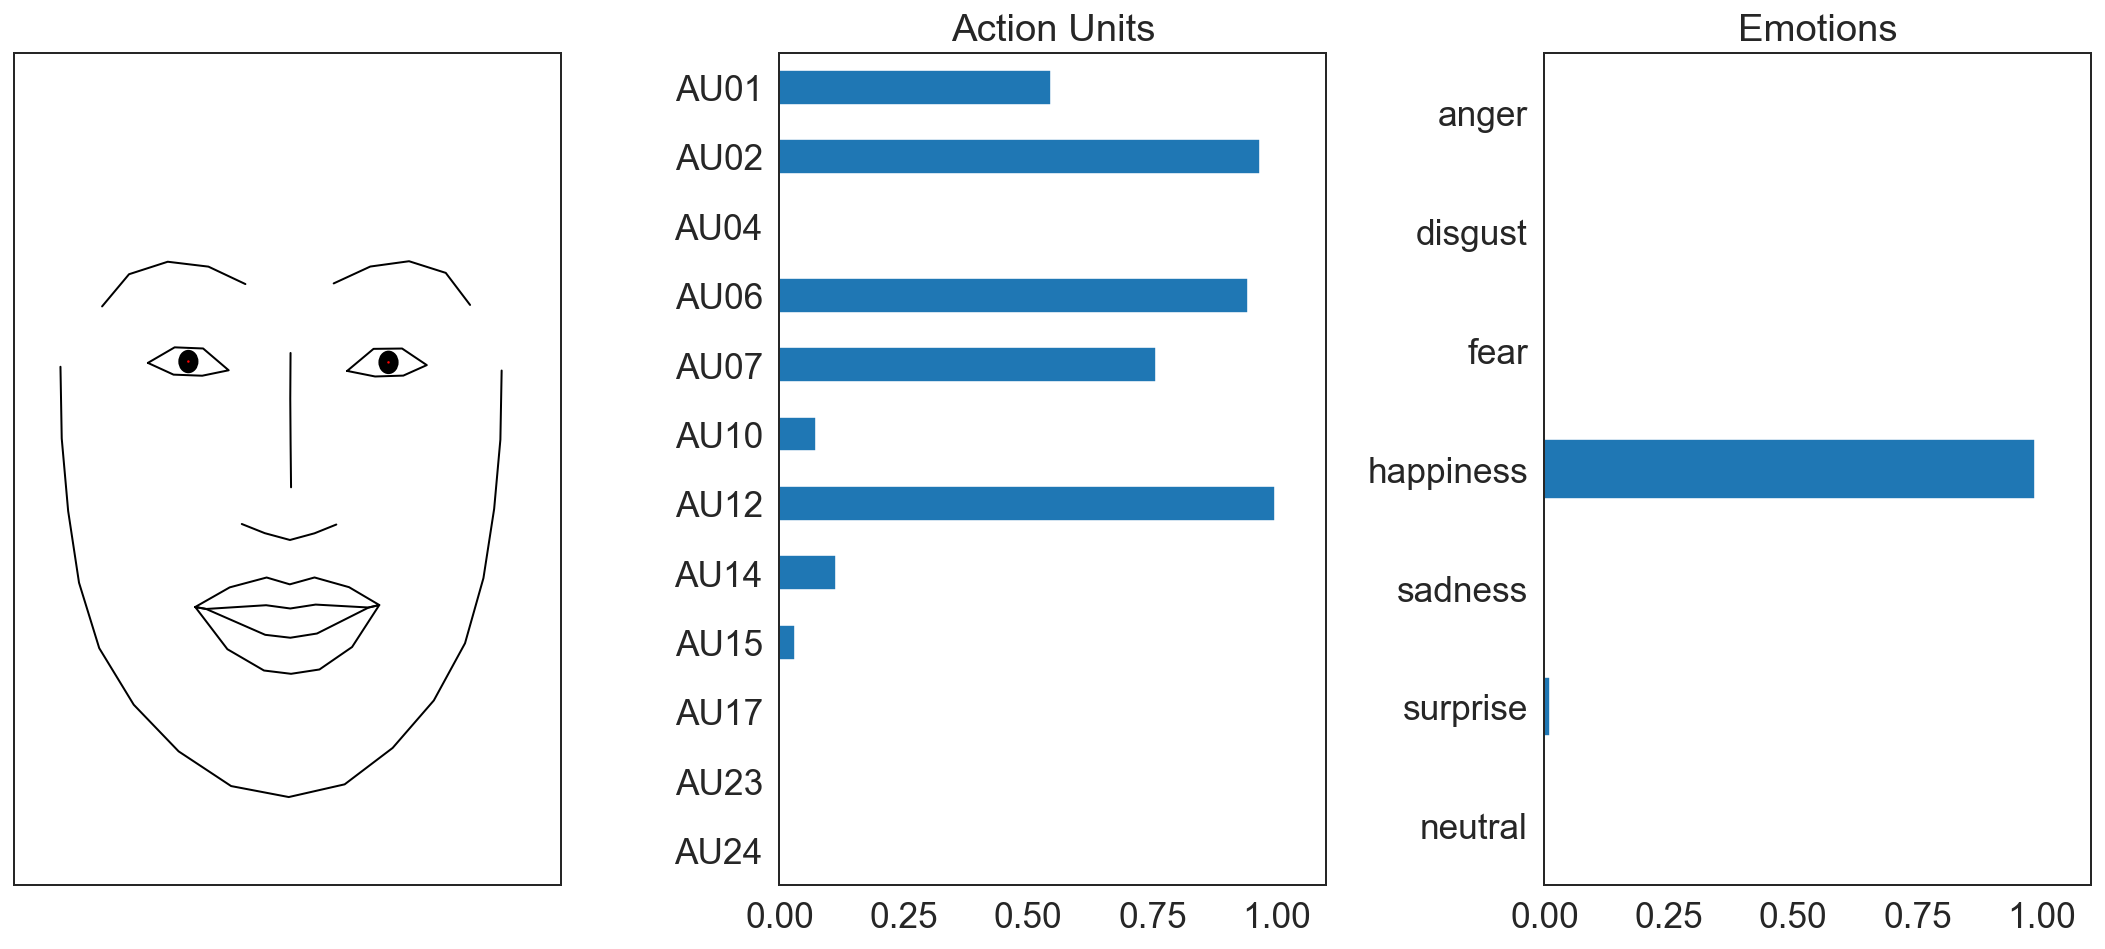

In [48]:
# Swap the AU detector to jaanet
detector.change_model(au_model='jaanet')
single_face_prediction = detector.detect_image(single_face_img_path)

# This will automatically switch the visualization model behind the scenes
# Notice the projected face is a bit different than our other model because there are
# fewer AUs in JAANET
figs = single_face_prediction.plot_detections(faces= 'aus', add_titles=False)